<a href="https://colab.research.google.com/github/Idrisbaba/Decarbonisation-Abuja/blob/main/Abuja_OD_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# 🚀 INSTALLATION (run once)
!pip install geopandas rasterio rasterstats h3pandas osmnx ellipsis  # Install required packages

# 📦 CORE UTILITIES
import os  # For file and directory operations
import uuid  # For generating unique identifiers
import pickle  # For serializing and deserializing data
import time  # For timing operations
import random  # For random sampling or shuffling
from pathlib import Path  # For cross-platform file path handling
from datetime import datetime  # For handling timestamps
from collections import defaultdict  # For dictionary with default values

# 🗺️ GEOSPATIAL LIBRARIES
import geopandas as gpd  # For handling geospatial data (e.g., shapefiles, GeoDataFrames)
import rasterio  # For reading and processing raster data
from rasterstats import zonal_stats  # For computing statistics on raster data within zones
import h3pandas  # For hexagonal grid analysis (H3 geospatial indexing)
from shapely.geometry import Point, box, LineString  # For creating and manipulating geometric objects
from shapely.validation import make_valid  # For fixing invalid geometries
from rasterio.mask import mask  # For masking raster data with geometries

# 🧮 MATH & DATA STRUCTURES
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation with DataFrames
from scipy.spatial import distance_matrix  # For computing distance matrices (e.g., Euclidean distances)

# 🚲 STREET NETWORK ANALYSIS
import osmnx as ox  # For retrieving and analyzing OpenStreetMap data (e.g., street networks)
import networkx as nx  # For graph-based network analysis

# 📊 VISUALIZATION
import matplotlib.pyplot as plt  # For plotting and visualization
import matplotlib.patches as mpatches  # For custom plot patches
from matplotlib.lines import Line2D  # For custom plot lines
import seaborn as sns  # For statistical visualizations (e.g., heatmaps)

# ⚙️ PARALLEL PROCESSING
from joblib import Parallel, delayed  # For parallel processing to improve performance

# 🌍 INTERACTIVE MAPPING
import folium  # For interactive maps
from folium import Map, GeoJson, CircleMarker, PolyLine, LayerControl, Element  # For map components and styling

# 🎨 STYLING FOR VISUALS
#%matplotlib inline  # Ensure plots display in Jupyter notebooks
plt.rcParams["figure.dpi"] = 100  # Set plot resolution
plt.style.use("dark_background")  # Set dark theme for plots
sns.set_palette("viridis")  # Set color palette for visualizations

In [ ]:
import pkg_resources

# List of packages to check
packages = ['numpy', 'rasterio', 'geopandas']  # Replace with your actual packages

# Print package names and versions
for pkg in packages:
    try:
        print(f"Package: {pkg_resources.get_distribution(pkg).key}, Version: {pkg_resources.get_distribution(pkg).version}")
    except pkg_resources.DistributionNotFound:
        print(f"Package: {pkg} is not installed")

This section mounts Google Drive in a Google Colab environment, which is necessary to access the input files stored in the Decarbonizing transportation directory

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

This section defines the base folder, output directory, and input file paths for the analysis, then checks if the files exist. This chunk organizes the project by defining paths for input data (population raster, shapefiles for Abuja boundaries, OSM roads, and Nigeria wards) and an output directory. It also verifies that the required input files are present in Google Drive, which is critical for ensuring the subsequent analysis steps can proceed without missing data.

In [ ]:
# Base folder
base_data_path = Path("/content/drive/My Drive/Decarbonizing transportation")
output_path = base_data_path / "Outputs"
output_path.mkdir(exist_ok=True)

# Input files
abujapop_path = base_data_path / "NGA_population_v2_1_gridded" / "abuja_population_clipped.tif"
abuja_shp_path = base_data_path / "Abuja" / "Abuja.shp"
osm_path = base_data_path / "NGA_OpenStreetMap" / "gis_osm_roads_free_1.shp"
ward_path = base_data_path / "NigeriaWardBoundaries" / "Nigeria_-_Ward_Boundaries.shp"

# File checks
for path in [abujapop_path, abuja_shp_path, osm_path, ward_path]:
    print(f"{'✅ Found' if path.exists() else '⚠️ File not found'}: {path}")


This chunk redefines (or confirms) the path to the Abuja population raster file and prints it to verify the file location. It’s a simple step to ensure the correct dataset is referenced for subsequent geospatial operations, such as population analysis.

In [ ]:
abujapop_path = base_data_path / "NGA_population_v2_1_gridded" / "abuja_population_clipped.tif"
print(abujapop_path)


This chunk examines the abuja_population_clipped.tif raster by printing its metadata and computing basic statistics on both raw and masked data. It’s a diagnostic step to verify the raster’s properties and data content before further processing, such as calculating statistics or visualizing the data.

In [ ]:
with rasterio.open(abujapop_path) as src:
    print("File name:", src.name)
    print("Width:", src.width)
    print("Height:", src.height)
    print("Number of bands:", src.count)
    print("Coordinate Reference System (CRS):", src.crs)
    print("Data type:", src.dtypes[0])
    print("Nodata value:", src.nodata)
    print("Pixel size:", src.res)
    # Read raw data to check values
    pop_data_raw = src.read(1, masked=False)
    print("Raw unique values:", np.unique(pop_data_raw)[:10])  # Print first 10 unique values
    print("Raw Min:", np.nanmin(pop_data_raw))
    print("Raw Max:", np.nanmax(pop_data_raw))
    print("Raw Mean:", np.nanmean(pop_data_raw))
    # Check masked data
    pop_data_masked = src.read(1, masked=True)
    print("Number of valid (unmasked) values:", np.ma.count(pop_data_masked))

In [ ]:
with rasterio.open(abujapop_path) as src:
    print(src.transform)

In [ ]:
try:
    with rasterio.open(abujapop_path) as src:
        transform = src.transform
        print("Geospatial Transform:")
        print(f"  Affine Matrix: {transform}")
        print(f"  Resolution (x, y): ({transform.a}, {-transform.e})")
        print(f"  Upper-Left Corner: ({transform.c}, {transform.f})")
        print(f"  CRS: {src.crs}")
        print(f"  Bounds: {src.bounds}")
except rasterio.errors.RasterioIOError as e:
    print(f"Error opening raster: {e}")
    raise

This chunk visualizes the Abuja population raster (abuja_population_clipped.tif) using rasterio.plot.show and matplotlib. The goal is to display the spatial distribution of population density across Abuja, which is a useful step for validating the raster data before using it in the origin-destination (OD) model.

In [ ]:
import rasterio
from rasterio.plot import show
with rasterio.open(abujapop_path) as src:
    plt.figure(figsize=(10, 10))
    show(src, cmap='viridis', title="Abuja Population Density")
    plt.show()

This chunk loads the Abuja administrative boundary from a shapefile (Abuja.shp), converts it to a GeoDataFrame using geopandas, reprojects it to EPSG:4326 (WGS84) for consistency with the population raster, and extracts its geometries as a list for tasks like masking rasters. It also prints the number of features to validate the loading process.

In [ ]:
#Loaded Abuja's administrative boundary as a GeoDataFrame
#Transformed it into EPSG:4326 (WGS84) for geographic consistency
#Extracted the raw geometry as a list for downstream tasks (like masking rasters)
# Load & clip Abuja boundary
abuja_gdf = gpd.read_file(abuja_shp_path).to_crs("EPSG:4326")
abuja_geom = [feature["geometry"] for feature in abuja_gdf.__geo_interface__["features"]]

# Validate
print("Abuja boundary loaded:", len(abuja_gdf))

This chunk loads Nigeria’s ward boundaries from a shapefile, reprojects them to match the CRS of the Abuja boundary GeoDataFrame, clips them to the Abuja boundary, filters out invalid geometries, saves the result as a GeoPackage, visualizes the clipped wards, and validates the number of wards. This step is crucial for your origin-destination (OD) model, as wards likely serve as the zones (origins and destinations) for trip calculations.

In [ ]:
# Load & clip ward boundaries to Abuja
ward_gdf = gpd.read_file(ward_path).to_crs(abuja_gdf.crs)
abuja_wards = gpd.clip(ward_gdf, abuja_gdf)
abuja_wards = abuja_wards[abuja_wards.is_valid]

# Save processed wards
abuja_wards.to_file(output_path / "abuja_wards_clipped.gpkg", driver="GPKG")

# Visual check
plt.style.use("dark_background")
abuja_wards.plot(facecolor="none", edgecolor="cyan", linewidth=0.6)
plt.title("Filtered Abuja Wards", color="lime")
plt.axis("equal")
plt.show()

# Validate
print("Number of wards:", len(abuja_wards))

In [ ]:
try:
    with rasterio.open(abujapop_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        rasterio.plot.show(src, cmap='viridis', ax=ax)
        abuja_wards.plot(ax=ax, facecolor="none", edgecolor="cyan", linewidth=0.6)
        plt.title("Abuja Wards over Population Density", color="lime")
        plt.xlabel("Longitude (degrees)")
        plt.ylabel("Latitude (degrees)")
        plt.colorbar(ax.get_images()[0], label="Population Density", fraction=0.046, pad=0.04)
        plt.axis("equal")
        plt.show()
except rasterio.errors.RasterioIOError as e:
    print(f"Error opening raster: {e}")
    raise

This chunk computes population estimates for each ward in Abuja by aggregating values from the population raster using zonal statistics, executed in parallel for efficiency. It then imputes missing or zero population values with the mean, validates the results, visualizes problematic wards, checks spatial bounds for debugging, verifies geometry validity, and saves the updated GeoDataFrame. This step is pivotal for the origin-destination (OD) model, as ward-level population data drives trip production estimates (e.g., more trips originate from populous wards)

In [ ]:
# Function to extract population from raster
def extract_pop(geom):
    stats = zonal_stats(geom, abujapop_path, stats=["sum"], nodata=-9999)
    return stats[0]["sum"] or 0

# Execute in parallel
abuja_wards["Population"] = Parallel(n_jobs=-1)(
    delayed(extract_pop)(geom) for geom in abuja_wards.geometry
)

# Replace NaN or zero populations with mean
mean_pop = abuja_wards["Population"].mean()
abuja_wards["Population"] = abuja_wards["Population"].fillna(mean_pop).replace(0, mean_pop)

# Validate population data
print("Population summary:")
print(abuja_wards[["wardname", "Population"]].describe())

invalid_wards = abuja_wards[abuja_wards["Population"] == mean_pop][["wardname", "Population", "geometry"]]
print("Wards with original NaN or zero population (now replaced with mean):")
print(invalid_wards[["wardname", "Population"]])

# Visualize problematic wards
invalid_wards_gdf = gpd.GeoDataFrame(invalid_wards, geometry="geometry", crs=abuja_wards.crs)
invalid_wards_gdf.plot(facecolor="red", edgecolor="black")
plt.title("Wards with Replaced Population (NaN or Zero)")
plt.axis("equal")
plt.show()

# Check raster and ward bounds
with rasterio.open(abujapop_path) as src:
    print("Raster bounds:", src.bounds)

print("Abuja wards bounds:", abuja_wards.total_bounds)
for _, ward in invalid_wards.iterrows():
    print(f"{ward['wardname']} bounds:", ward["geometry"].bounds)

# Check for invalid geometries
invalid_geoms = abuja_wards[~abuja_wards.geometry.is_valid][["wardname"]]
print("Invalid geometries:", invalid_geoms)

# Save updated wards
abuja_wards.to_file(output_path / "abuja_wards_with_population.gpkg", driver="GPKG")


In [ ]:
min_pop_ward = abuja_wards[abuja_wards["Population"] == abuja_wards["Population"].min()][["wardname", "Population", "geometry"]]
print("Ward with minimum population:")
print(min_pop_ward[["wardname", "Population"]])
print("Bounds:", min_pop_ward.geometry.bounds.iloc[0])

In [ ]:
        karimo_buga = abuja_wards[abuja_wards["wardname"] == "Karimo-Buga"]
area_km2 = karimo_buga.geometry.area.iloc[0] * (111**2)  # Approx km² in EPSG:4326
print(f"Karimo-Buga area: {area_km2:.2f} km²")

This chunk sorts the abuja_wards GeoDataFrame by population in descending order and creates a bar chart to visualize the population distribution across wards in Abuja.

In [ ]:
# Sort wards by population
abuja_wards_sorted = abuja_wards.sort_values("Population", ascending=False)

# Bar chart
abuja_wards_sorted.plot(
    x="wardname",
    y="Population",
    kind="bar",
    figsize=(14, 6),
    color="coral",
    edgecolor="black"
)

plt.title("Population by Ward in Abuja", fontsize=14)
plt.xlabel("Wards")
plt.ylabel("Population")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [ ]:
# Plot population distribution across Abuja wards
fig, ax = plt.subplots(figsize=(12, 10))
plt.style.use("dark_background")

abuja_wards.plot(
    column="Population",
    cmap="OrRd",  # orange-red gradient
    linewidth=0.5,
    edgecolor="gray",
    legend=True,
    ax=ax
)

# Add title and styling
ax.set_title("Population Distribution Across Abuja Wards", fontsize=14, color="white")
ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Create population bins
abuja_wards["Tier"] = pd.qcut(
    abuja_wards["Population"], q=5,
    labels=["Very Low", "Low", "Medium", "High", "Very High"]
)

# Count number of wards per tier
ward_counts = abuja_wards["Tier"].value_counts().sort_index()

# Plot tier distribution
ward_counts.plot(
    kind="bar",
    color="steelblue",
    edgecolor="black",
    figsize=(10, 6)
)

plt.title("Number of Wards per Population Tier", fontsize=14)
plt.xlabel("Tier")
plt.ylabel("Number of Wards")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
abuja_wards["Tier"] = pd.qcut(abuja_wards["Population"], q=5, labels=["Very Low", "Low", "Medium", "High", "Very High"])


Uses pd.qcut from pandas to divide the "Population" column of the abuja_wards GeoDataFrame into 5 quantiles. This ensures an equal distribution of wards across five population categories, regardless of the absolute population differences. This categorization helps identify wards with similar population densities, which can correlate with trip generation rates in an OD model. For example, "Very High" tiers might represent urban centers with high trip production, while "Very Low" tiers might indicate rural or less populated areas with fewer trips.

In [ ]:
abuja_wards.plot(column="Tier", cmap="coolwarm", legend=True, figsize=(12, 10))
plt.title("Demand Tier Classification by Population")
plt.axis("off")
plt.tight_layout()
plt.show()


This chunk enriches our dataset with destination points, a critical component for modeling travel flows, This step moves our OD model toward trip distribution by linking population-based origins (wards) with POI-based destinations.

In [ ]:
# Load full POI dataset
pois_path = base_data_path / "NGA_OpenStreetMap" / "gis_osm_pois_a_free_1.shp"
pois_gdf = gpd.read_file(pois_path).to_crs(abuja_gdf.crs)

# Clip POIs to Abuja boundary
abuja_pois = gpd.clip(pois_gdf, abuja_gdf)

# Visual inspection
print(abuja_pois[["name", "fclass"]].head())
print(f"📍 Total POIs in Abuja: {len(abuja_pois)}")

Explanation of the Code Chunk:
This chunk refines the Points of Interest (POIs) dataset for our Origin-Destination (OD) model aimed at decarbonizing transportation in Abuja. It filters and processes the POIs to focus on travel-relevant categories, handles geometric variations (points and polygons), and prepares a unified dataset for modeling. This step is crucial for defining trip destinations and integrating them with population-based origins (wards) to simulate travel demand and optimize low-carbon transport solutions.

In [ ]:
# Filter POIs by travel-relevant categories
target_categories = [
    "school", "university", "college",
    "hospital", "clinic", "pharmacy",
    "supermarket", "mall", "market_place",
    "park", "stadium", "sports_centre", "pitch",
    "courthouse", "embassy", "public_building",
    "community_centre", "library", "post_office"
]

# Step 1: Filter for relevant categories
abuja_pois_filtered = abuja_pois[abuja_pois["fclass"].isin(target_categories)]

# Step 2: Limit pitch POIs to reduce dominance
pitch_limit = 50
if len(abuja_pois_filtered[abuja_pois_filtered["fclass"] == "pitch"]) > pitch_limit:
    pitch_pois = abuja_pois_filtered[abuja_pois_filtered["fclass"] == "pitch"].sample(n=pitch_limit, random_state=42)
    other_pois = abuja_pois_filtered[abuja_pois_filtered["fclass"] != "pitch"]
    abuja_pois_filtered = pd.concat([other_pois, pitch_pois], ignore_index=True)

# Step 3: Separate points and polygons
point_pois = abuja_pois_filtered[abuja_pois_filtered.geometry.type == "Point"].copy()
poly_pois = abuja_pois_filtered[abuja_pois_filtered.geometry.type != "Point"].copy()

# Step 4: Project polygons to EPSG:3857 for centroid calculation
projected_crs = "EPSG:3857"
poly_pois = poly_pois.to_crs(projected_crs)
poly_pois["geometry"] = poly_pois.geometry.centroid

# Step 5: Merge into a unified, point-based dataset in projected CRS
point_pois = point_pois.to_crs(projected_crs)
abuja_pois_model = pd.concat([point_pois, poly_pois], ignore_index=True)

# Save to file
abuja_pois_model.to_file(output_path / "abuja_pois_filtered.gpkg", driver="GPKG")

# Visual check
print(f"✅ Modeling POIs ready: {len(abuja_pois_model)}")
print(abuja_pois_model["fclass"].value_counts())

This chunk introduces the road network data into our Origin-Destination (OD) model for Abuja. It loads, clips, and visualizes the road network based on OpenStreetMap (OSM) data, which is a critical step for modeling travel routes and optimizing low-carbon transport solutions.

this is all part of data enrichment

In [ ]:
# Load & clip roads to Abuja
osm_roads_gdf = gpd.read_file(osm_path).to_crs(abuja_gdf.crs)
abuja_roads = gpd.clip(osm_roads_gdf, abuja_gdf)
abuja_roads = abuja_roads[abuja_roads.is_valid]

# Save clipped roads
abuja_roads.to_file(output_path / "clipped_abuja_roads.shp")

# Visualize
abuja_roads.plot(color="white", linewidth=0.5)
plt.title("Road Network in Abuja", color="lime")
plt.axis("equal")
plt.show()


# This code prepares a drivable road network graph for Abuja using osmnx, integrating it into the OD model for decarbonization.
# It consolidates the Abuja boundary, downloads a dense road network, projects it to a metric CRS, simplifies it, and extracts the largest connected component.
# The graph will support trip routing, distance calculations, and decarbonization simulations (e.g., EV lanes, public transit optimization).


In [ ]:
# Combine Abuja boundary into one polygon
abuja_poly = abuja_gdf.geometry.union_all()

# Create street graph with denser network
G_proj = ox.graph_from_polygon(abuja_poly, network_type="drive", simplify=False)

# Project to metric CRS
G_proj = ox.project_graph(G_proj)

# Simplify graph if not already simplified
simplified = G_proj.graph.get("simplified", False)
G_proj = ox.simplify_graph(G_proj) if not simplified else G_proj
if not simplified:
    print("Graph simplified to reduce computation time")

# Check connectivity
all_nodes = set(G_proj.nodes)
num_components = nx.number_strongly_connected_components(G_proj)
print("Number of connected components:", num_components)

largest_cc = max(nx.strongly_connected_components(G_proj), key=len)
G_proj = G_proj.subgraph(largest_cc).copy()
excluded_nodes = all_nodes - set(G_proj.nodes)

print("Extracted largest connected component with nodes:", len(G_proj.nodes))
print("Sample nodes in largest component:", list(largest_cc)[:5])
print("Number of excluded nodes:", len(excluded_nodes))
print("Sample excluded nodes:", list(excluded_nodes)[:5])

# Save excluded nodes for debugging
Path(output_path).mkdir(parents=True, exist_ok=True)
Path(output_path / "excluded_nodes.txt").write_text("\n".join(map(str, excluded_nodes)))

# Visualize largest component
ox.plot_graph(G_proj, node_size=0, edge_color="lightgray", edge_linewidth=0.5, show=False)
plt.title("Largest Connected Component of Road Network")
plt.axis("equal")
plt.show()

# Save graph
ox.save_graphml(G_proj, filepath=base_data_path / "abuja_roads.graphml")

# Validate
print("Graph created with nodes:", len(G_proj.nodes), "and edges:", len(G_proj.edges))
print("Graph CRS:", G_proj.graph["crs"])


this chunk serves as a simple validation step to check the existence of the abuja_roads.graphml

In [ ]:
# Confirm the graph file exists
graph_path = base_data_path / "abuja_roads.graphml"
status = "Saved:" if graph_path.exists() else "Not saved:"
print(status, graph_path)


This loads the graph for further analysis

In [ ]:
# Load the pre-saved road graph
G_proj = ox.load_graphml(base_data_path / "abuja_roads.graphml")

This chunk enhances our Origin-Destination (OD) model for Abuja by integrating the Points of Interest (POIs) with the road network graph, a critical step for accurately modeling travel routes and supporting decarbonization goals. It loads excluded nodes from the previous graph processing, reprojects POIs to match the graph's coordinate system, snaps POIs to the nearest nodes in the road network, validates the snapping process, and saves the updated dataset. This prepares the data for trip assignment and route optimization.

In [ ]:
# Load excluded nodes
excluded_nodes_path = output_path / "excluded_nodes.txt"
excluded_nodes = (
    set(map(int, excluded_nodes_path.read_text().splitlines()))
    if excluded_nodes_path.exists()
    else set()
)
if not excluded_nodes:
    print("Warning: excluded_nodes.txt not found")

# Reproject POIs
abuja_pois_model = abuja_pois_model.to_crs(G_proj.graph["crs"])

# Extract coordinates
coords = [(pt.x, pt.y) for pt in abuja_pois_model.geometry]

# Snap POIs to nearest nodes
abuja_pois_model["nearest_node"] = Parallel(n_jobs=-1, batch_size=32)(
    delayed(lambda xy: ox.distance.nearest_nodes(G_proj, xy[0], xy[1]))(xy) for xy in coords
)

# Identify invalid nodes
invalid_nodes = abuja_pois_model[~abuja_pois_model["nearest_node"].isin(G_proj.nodes)]

if not invalid_nodes.empty:
    print("POIs with invalid nearest nodes:", len(invalid_nodes))
    print(invalid_nodes[["name", "fclass", "nearest_node"]].head())

    invalid_in_excluded = invalid_nodes[invalid_nodes["nearest_node"].isin(excluded_nodes)]
    if not invalid_in_excluded.empty:
        print("Invalid POI nodes in excluded_nodes:", len(invalid_in_excluded))
        print(invalid_in_excluded[["name", "fclass", "nearest_node"]].head())

    univ_poi = invalid_nodes[invalid_nodes["name"] == "University of Abuja"]
    if not univ_poi.empty:
        print("Warning: University of Abuja has invalid node:")
        print(univ_poi[["name", "nearest_node"]])

# Save snapped POIs
abuja_pois_model.to_file(output_path / "abuja_model_pois.gpkg", layer="POIs", driver="GPKG")

# Validate snapping
print("Unique POI nearest nodes:", abuja_pois_model["nearest_node"].nunique())
print("Top 5 most common POI nearest nodes:")
print(abuja_pois_model["nearest_node"].value_counts().head())
print(abuja_pois_model[["name", "fclass", "nearest_node"]].head())


this chunk provides a basic validation step for the abuja_pois_model GeoDataFrame, which contains the Points of Interest (POIs) snapped to the nearest nodes in the road network graph for your Origin-Destination (OD) model aimed at decarbonizing transportation in Abuja. By printing the total number of POIs and their geometric bounds, this code ensures the dataset's integrity and spatial extent, serving as a checkpoint before further OD analysis.


In [ ]:
print("POIs in model:", len(abuja_pois_model))
print("Geometry bounds:", abuja_pois_model.total_bounds)


This chunk continues the preparation of your Origin-Destination (OD) model for Abuja by integrating the wards (as trip origins) with the road network graph. It reprojects the wards to match the graph's CRS, calculates and snaps ward centroids to the nearest graph nodes, validates the snapping (including a specific check for "Nyanya 1"), cleans up the data, saves it, and provides summary statistics. This step mirrors the POI snapping process but for origins, enabling accurate OD matrix calculations using the network.

In [ ]:
# Load excluded nodes
excluded_nodes_path = output_path / "excluded_nodes.txt"
excluded_nodes = (
    set(map(int, excluded_nodes_path.read_text().splitlines()))
    if excluded_nodes_path.exists()
    else set()
)
if not excluded_nodes:
    print("Warning: excluded_nodes.txt not found")

# Reproject wards to match graph CRS
abuja_wards = abuja_wards.to_crs(G_proj.graph["crs"])

# Create and extract centroids
abuja_wards["centroid"] = abuja_wards.geometry.centroid
ward_coords = [(pt.x, pt.y) for pt in abuja_wards["centroid"]]

# Snap centroids to nearest graph nodes
abuja_wards["nearest_node"] = Parallel(n_jobs=-1, batch_size=32)(
    delayed(lambda xy: ox.distance.nearest_nodes(G_proj, xy[0], xy[1]))(xy)
    for xy in ward_coords
)

# Check snapped node validity
invalid_nodes = abuja_wards[~abuja_wards["nearest_node"].isin(G_proj.nodes)]
if not invalid_nodes.empty:
    print("Wards with invalid nearest nodes:", len(invalid_nodes))
    print(invalid_nodes[["wardname", "nearest_node"]])

    invalid_in_excluded = invalid_nodes[invalid_nodes["nearest_node"].isin(excluded_nodes)]
    if not invalid_in_excluded.empty:
        print("Invalid ward nodes in excluded_nodes:", len(invalid_in_excluded))
        print(invalid_in_excluded[["wardname", "nearest_node"]])

# Specific check: Nyanya 1
nyanya_row = abuja_wards[abuja_wards["wardname"] == "Nyanya 1"]
if not nyanya_row.empty:
    nyanya_node = nyanya_row.iloc[0]["nearest_node"]
    print("Nyanya 1 nearest node:", nyanya_node)

    if nyanya_node not in G_proj.nodes:
        print("Warning: Nyanya 1 node not in graph!")
        if nyanya_node in excluded_nodes:
            print("Nyanya 1 node is in excluded_nodes!")

        nyanya_row.geometry.centroid.plot(color="red", markersize=50)
        plt.title("Nyanya 1 Centroid")
        plt.axis("equal")
        plt.show()

# Cleanup and save
abuja_wards.drop(columns=["centroid"], inplace=True)
abuja_wards.to_file(output_path / "abuja_wards_processed.gpkg", driver="GPKG")

# Validate results
print("Unique ward nearest nodes:", abuja_wards["nearest_node"].nunique())
print("Top 5 most common ward nearest nodes:")
print(abuja_wards["nearest_node"].value_counts().head())
print(abuja_wards[["wardname", "nearest_node"]].head())
print("Columns in abuja_wards:", abuja_wards.columns.tolist())


### Explanation Chunk to Include Before Running the Code:

This code chunk is ver iportant and technical step in building our Origin-Destination (OD) model for decarbonizing transportation in Abuja, as it computes the network-based distance matrix between ward nodes (trip origins) and POI nodes (trip destinations). This matrix represents the shortest path distances along the actual road network (in meters), providing a realistic measure of travel impedance. It uses Dijkstra's algorithm for shortest paths, which is efficient for graphs with non-negative weights (here, edge lengths). The process runs in parallel to handle computation for 77 ward nodes and 250 POI nodes, identifies unreachable pairs (e.g., due to network disconnects), and saves the results for later use in trip distribution models like gravity formulations.

The code begins by extracting unique ward and POI nodes from their respective GeoDataFrames. It defines a function to compute distances from one ward node to all POI nodes using networkx's `single_source_dijkstra_path_length`, which applies Dijkstra's algorithm to find minimum path lengths weighted by "length" (road segment distances). Parallel execution distributes the workload across CPU cores for speed. The resulting matrix is a dictionary (ward_node: {poi_node: distance}), with unreachable destinations marked as infinity. It saves this matrix via pickle for persistence, validates with samples, detects unreachable pairs by linking back to ward/POI names, and computes statistics on valid distances (min, max, mean) to summarize travel patterns.

This step is crucial because Euclidean distances (straight-line) often underestimate urban travel costs; network distances account for road topology, enabling accurate OD flow estimation. For decarbonization, shorter distances might promote walking/biking, while long/unreachable ones highlight needs for infrastructure (e.g., bridges) or mode shifts (e.g., public transit) to reduce CO2. Unreachable pairs could indicate OSM data gaps, requiring manual fixes or alternative routing assumptions.

```python
# [Explanation Chunk]
# This code computes the shortest path distance matrix between ward nodes (origins) and POI nodes (destinations) using Dijkstra's algorithm on the projected road graph.
# It extracts unique nodes, runs parallel computations for efficiency, handles unreachable pairs (inf distances), saves the matrix via pickle, and validates with samples and stats.
# The matrix is essential for gravity-based trip distribution, where distance acts as impedance in formulas like Trips_ij = (Prod_i * Attr_j) / f(dist_ij).
# Note: If many unreachable pairs, investigate graph connectivity; distances are in meters from the metric CRS.
```

This explanation should precede the code to clarify its technical aspects and tie into your OD methodology. After running, review unreachable pairs and stats to refine the model—e.g., if mean distance is high, it could inform decarbonization priorities. Let me know if you need adjustments or the next chunk!

In [ ]:
# Get unique ward and POI nodes
ward_nodes = abuja_wards["nearest_node"].unique().tolist()
poi_nodes = abuja_pois_model["nearest_node"].unique().tolist()

Uses Dijkstra’s algorithm to compute shortest path lengths from a ward node `w_node` to all other nodes in the graph `G`.

**Formula:**

$$
\text{dist}(u, v) = \min_{\text{path } P \text{ from } u \text{ to } v} \sum_{e \in P} \text{length}(e)
$$

Where:
- \( u \) is the source node (ward),
- \( v \) is the target node (POI),
- \( P \) is any valid path from \( u \) to \( v \),
- \( e \in P \) are the edges in that path,
- \( \text{length}(e) \) is the weight (distance) of edge \( e \).

If a POI node is unreachable, its distance is set to `float("inf")`.


In [ ]:
#Define Distance Computation Function
def compute_distances(w_node, poi_nodes, G):
    lengths = nx.single_source_dijkstra_path_length(G, w_node, weight="length")
    return w_node, {p: lengths.get(p, float("inf")) for p in poi_nodes}


In [ ]:
#Parallel Computation of Distance Matrix
results = Parallel(n_jobs=-1)(
    delayed(compute_distances)(w_node, poi_nodes, G_proj) for w_node in ward_nodes
)
dist_matrix = dict(results)


In [ ]:
# Save Distance Matrix
# Stores the computed matrix as a .pkl file for later use.
pickle_path = output_path / "ward_poi_dist_matrix.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(dist_matrix, f)

# Validate
print("Computed distances for", len(dist_matrix), "ward nodes")
sample = {k: list(v.items())[:5] for k, v in list(dist_matrix.items())[:2]}
print("Sample distances:", sample)


In [ ]:
# Detect unreachable POI nodes
unreachable = []
for w_node, distances in dist_matrix.items():
    ward_df = abuja_wards[abuja_wards["nearest_node"] == w_node]
    ward_name = ward_df["wardname"].iloc[0] if not ward_df.empty else "Unknown"

    for p_node, dist in distances.items():
        if dist == float("inf"):
            poi_df = abuja_pois_model[abuja_pois_model["nearest_node"] == p_node]
            poi_name = poi_df["name"].iloc[0] if not poi_df.empty else f"POI_{p_node}"
            unreachable.append((ward_name, poi_name, w_node, p_node))

print("Number of unreachable ward-POI pairs:", len(unreachable))

# Detect Unreachable POIs
if unreachable:
    print("Sample unreachable pairs:", unreachable[:5])

# Compute Distance Statistics
valid_distances = [
    d for distance_map in dist_matrix.values() for d in distance_map.values() if d != float("inf")
]
print(f"Distance stats (meters): min={min(valid_distances):.2f}, max={max(valid_distances):.2f}, mean={np.mean(valid_distances):.2f}")

#Spatial interaction
this Creates flow records between wards and POIs using an **exponential distance decay model**, which assumes that interaction strength decreases with increasing distance.

**Flow Score Formula:**

$$
\text{flow\_score} = \text{Population}_{\text{ward}} \times e^{-\frac{\text{distance}}{10{,}000}}
$$

Where:
- `$ \text{Population}_{\text{ward}} $` is the population of the ward,
- `$ \text{distance} $` is the shortest path distance (in meters) between the ward and POI,
- The decay constant `$ 10{,}000 $` meters controls how quickly the interaction diminishes with distance.

**Logic Summary:**
- Wards with missing or non-positive population are skipped.
- POIs with missing, infinite, or overly large distances (>150 km) are excluded.
- Valid ward–POI pairs are scored using the exponential decay formula.
- Results are saved to a CSV and summarized with basic statistics.

**Note:** This model is commonly used in spatial interaction and gravity models to simulate accessibility or service reach.

this chunk also generates "flow records" estimating potential travel demand (flows) between wards (origins) and POIs (destinations) using a distance decay function, which acts as a basic gravity model proxy. Flows are scored based on ward population and exponential decay of distance, filtering out invalid or excessive distances.

max_distance = 150_000 (150km) and min_distance = 100 (100m):

Defines thresholds: Distances over 150km are skipped (e.g., to exclude unrealistic city-wide trips), and a minimum offset (not directly use

flow_score = w_pop * np.exp(-dist / 10_000):

w_pop (Ward Population): This is the population of the ward, sourced from the abuja_wards GeoDataFrame’s "Population" column. It represents the trip production capacity of the ward—i.e., the number of potential trips originating from that area. A higher population typically generates more trips, making it a key driver of flow.

dist (Distance): This is the shortest path distance (in meters) between the ward’s nearest node and the POI’s nearest node, retrieved from the precomputed dist_matrix. It reflects the travel impedance, with longer distances generally reducing the likelihood of trips due to time, cost, or convenience.
np.exp(-dist / 10_000) (Exponential Decay Function):

The np.exp() function from NumPy computes the exponential of an expression.
The argument -dist / 10_000 normalizes the distance by dividing it by 10,000 meters (10 km), which acts as the decay parameter (often denoted as β in gravity models).
The negative sign ensures the exponent decreases as distance increases, making the exponential term smaller. For example:

In [ ]:
# Create flow records with distance decay
flows = []
invalid_pairs = []
max_distance = 150_000  # 150km threshold
min_distance = 100      # 100m offset for inverse formula if used

for _, ward in abuja_wards.iterrows():
    w_node = ward["nearest_node"]
    w_pop = ward["Population"]

    if pd.isna(w_pop) or w_pop <= 0:
        invalid_pairs.append((ward["wardname"], "Invalid population", w_pop))
        continue

    for _, poi in abuja_pois_model.iterrows():
        p_node = poi["nearest_node"]
        dist = dist_matrix.get(w_node, {}).get(p_node)

        if dist is None or dist == float("inf") or dist > max_distance:
            poi_name = poi.get("name") or f"{poi['fclass']}_{poi['osm_id']}"
            invalid_pairs.append((ward["wardname"], poi_name, "Invalid or too large distance"))
            continue

        flow_score = w_pop * np.exp(-dist / 10_000)  # Exponential decay

        poi_name = poi.get("name") or f"{poi['fclass']}_{poi['osm_id']}"
        flows.append({
            "ward": ward["wardname"],
            "poi": poi_name,
            "fclass": poi["fclass"],
            "distance_m": dist,
            "population": w_pop,
            "flow_score": flow_score
        })

# Save DataFrame
flow_df = pd.DataFrame(flows)
flow_df.to_csv(output_path / "flows.csv", index=False)

# Validation summary
print("Created", len(flow_df), "flow records")
print("First 5 flows:")
print(flow_df[["ward", "poi", "flow_score", "population", "distance_m"]].head())

print("Top POIs by flow score:")
print(flow_df.groupby("poi")["flow_score"].sum().sort_values(ascending=False).head(10))

print("Invalid ward-POI pairs:", len(invalid_pairs))
if invalid_pairs:
    print("Sample invalid pairs:", invalid_pairs[:5])

distances = flow_df["distance_m"]
print(f"Distance stats for flows (meters): min={distances.min():.2f}, max={distances.max():.2f}, mean={distances.mean():.2f}")

# Nyanya 1 specific summary
nyanya_flows = flow_df[flow_df["ward"] == "Nyanya 1"]
if not nyanya_flows.empty:
    print("Nyanya 1 flow stats:")
    print(nyanya_flows[["poi", "flow_score", "distance_m"]].head())
    print("Nyanya 1 valid pairs:", len(nyanya_flows))
    print(f"Nyanya 1 distance stats (meters): min={nyanya_flows['distance_m'].min():.2f}, max={nyanya_flows['distance_m'].max():.2f}, mean={nyanya_flows['distance_m'].mean():.2f}")
else:
    print("Warning: No flows for Nyanya 1")


Generates spatial flow lines between ward centroids and POI locations using flow scores from the previously computed dataset.

### 🗺️ Workflow Summary

1. **Load Data:**
   - Wards and POIs are loaded from GeoPackage files.
   - Flow records are loaded from a CSV file.

2. **Coordinate Reference System (CRS):**
   - All geometries are reprojected to EPSG:32632 (UTM Zone 32N) for accurate distance calculations.

3. **Generate Flow Lines:**
   - For each flow record:
     - Find the corresponding ward and POI geometries.
     - If POI name is missing, fallback to `osm_id` using the format `fclass_osm_id`.
     - Create a `LineString` from the ward centroid to the POI location.
     - Store metadata including flow score and distance.

4. **Filter and Save:**
   - Only flow lines with `flow_score > 1000` are retained.
   - Results are saved to a GeoPackage file.

### 📐 Flow Line Geometry

Each flow line is defined as:

$$
\text{LineString}(\text{Centroid}_{\text{ward}}, \text{Location}_{\text{POI}})
$$

Where:
- `Centroid_{ward}` is the geometric center of the ward polygon.
- `Location_{POI}` is the point geometry of the POI.

### 📊 Output Summary

- Number of flow lines created.
- Sample of top flows.
- Flow score statistics:
  - Minimum
  - Maximum
  - Mean

This visualization helps identify high-intensity connections between population centers and services or amenities.


In [ ]:
# Load data
abuja_wards = gpd.read_file(output_path / "abuja_wards_processed.gpkg")
abuja_pois_model = gpd.read_file(output_path / "abuja_model_pois.gpkg", layer="POIs")
flow_df = pd.read_csv(output_path / "flows.csv")

# Ensure consistent CRS
abuja_wards = abuja_wards.to_crs(epsg=32632)
abuja_pois_model = abuja_pois_model.to_crs(epsg=32632)

# Generate flow lines
flow_lines = []
for _, row in flow_df.iterrows():
    ward = abuja_wards[abuja_wards["wardname"] == row["ward"]]
    poi = abuja_pois_model[abuja_pois_model["name"] == row["poi"]]

    if poi.empty and "_" in row["poi"]:
        poi_id = row["poi"].split("_")[-1]
        poi = abuja_pois_model[abuja_pois_model["osm_id"] == poi_id]

    if ward.empty or poi.empty:
        continue

    line = LineString([ward.geometry.centroid.iloc[0], poi.geometry.iloc[0]])
    flow_lines.append({
        "ward": row["ward"],
        "poi": row["poi"],
        "flow_score": row["flow_score"],
        "distance_m": row["distance_m"],
        "geometry": line
    })

# Create GeoDataFrame and filter
flow_gdf = gpd.GeoDataFrame(flow_lines, geometry="geometry", crs="EPSG:32632")
flow_gdf = flow_gdf[flow_gdf["flow_score"] > 1000]

# Save to file
flow_gdf.to_file(output_path / "flow_lines.gpkg", driver="GPKG")

# Summary
print("Created", len(flow_gdf), "flow lines with flow_score > 1000")
print("Sample flow lines:")
print(flow_gdf[["ward", "poi", "flow_score", "distance_m"]].head())

flow_stats = flow_gdf["flow_score"].agg(["min", "max", "mean"])
print("Flow score stats: min={:.2f}, max={:.2f}, mean={:.2f}".format(*flow_stats))


In [ ]:
import geopandas as gpd
import folium
from folium import GeoJson, Map, LayerControl, Element

# Load Nigeria states and Abuja
nigeria_states_gdf = gpd.read_file(base_data_path / "Nigeria" / "ng.shp").to_crs("EPSG:4326")
abuja_gdf = gpd.read_file(abuja_shp_path).to_crs("EPSG:4326")

# Clean for folium compatibility
def clean_gdf(gdf):
    allowed = gdf.select_dtypes(include=["object", "float", "int", "bool"])
    return gpd.GeoDataFrame(allowed, geometry=gdf.geometry)

clean_nigeria = clean_gdf(nigeria_states_gdf)
clean_abuja = clean_gdf(abuja_gdf)

# Compute map center from Nigeria bounds
bounds = clean_nigeria.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Create the folium map
m = Map(location=[center_lat, center_lon], zoom_start=6, tiles="CartoDB positron")

# Add Nigeria states layer
GeoJson(
    clean_nigeria,
    name="Nigeria States",
    style_function=lambda x: {
        "fillOpacity": 0,
        "color": "gray",
        "weight": 1
    }
).add_to(m)

# Highlight Abuja with distinctive style
GeoJson(
    clean_abuja,
    name="Study Area: Abuja",
    style_function=lambda x: {
        "fillOpacity": 0.3,
        "color": "red",
        "weight": 3
    }
).add_to(m)

# Add legend for context
legend_html = """
<div style="
    position: fixed;
    bottom: 20px;
    left: 20px;
    width: 180px;
    z-index:9999;
    background-color:white;
    padding: 10px;
    border:2px solid gray;
    border-radius:8px;
    font-size:14px;
">
<b>Legend</b><br>
<span style="color:gray;">&#9644;</span> Nigeria States<br>
<span style="color:red;">&#9644;</span> Study Area: Abuja
</div>
"""
m.get_root().html.add_child(Element(legend_html))

# Add layer control
LayerControl().add_to(m)

# Save and display
m.save(output_path / "nigeria_study_area_map.html")
m


In [ ]:
# Load shapefiles
nigeria_states_gdf = gpd.read_file(base_data_path / "Nigeria" / "ng.shp")
abuja_gdf = gpd.read_file(abuja_shp_path)

# Reproject to geographic coordinates (EPSG:4326)
nigeria_states_gdf = nigeria_states_gdf.to_crs(epsg=4326)
abuja_gdf = abuja_gdf.to_crs(epsg=4326)

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 12))
fig.patch.set_facecolor("#1c1c1c")
ax.set_facecolor("#1c1c1c")

# Plot Nigeria states
nigeria_states_gdf.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=1)

# Highlight Abuja
abuja_gdf.plot(ax=ax, edgecolor="red", facecolor="lightcoral", linewidth=2)

# Label states
for _, row in nigeria_states_gdf.iterrows():
    if row.geometry.is_empty:
        continue
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y, row["name"],
        fontsize=9, fontweight="bold", family="sans-serif",
        ha="center", va="center", color="lightcyan",
        bbox=dict(facecolor="black", edgecolor="none", alpha=0.5, boxstyle="round,pad=0.2")
    )

# Add blue north arrow in top-right
ax.annotate(
    'N',
    xy=(0.95, 0.95), xytext=(0.95, 0.87),
    arrowprops=dict(facecolor='deepskyblue', width=5, headwidth=15),
    ha='center', va='center',
    fontsize=16, fontweight="bold", color='deepskyblue',
    xycoords='axes fraction'
)

# Add manual scale bar (approximate for visualization purposes only)
# You can adjust lon/lat positions based on visible map extent
scale_lon = nigeria_states_gdf.total_bounds[0] + 1  # Start point longitude
scale_lat = nigeria_states_gdf.total_bounds[1] + 0.5  # Start point latitude
scale_length_deg = 1.0  # degrees longitude ≈ ~111 km at equator

ax.plot(
    [scale_lon, scale_lon + scale_length_deg],
    [scale_lat, scale_lat],
    color="white", linewidth=3
)
ax.text(
    scale_lon + scale_length_deg / 2, scale_lat - 0.1,
    "Approx. 100 km", color="white", ha="center", fontsize=9
)

# Add coordinate boundaries
ax.set_xlabel("Longitude (°)", fontsize=10, color="white")
ax.set_ylabel("Latitude (°)", fontsize=10, color="white")
ax.tick_params(axis='both', which='major', labelsize=8, colors='white', direction='out', length=5, width=1)

# Legend with custom patches
legend_patches = [
    mpatches.Patch(edgecolor="gray", facecolor="none", label="Nigeria States", linewidth=1),
    mpatches.Patch(edgecolor="red", facecolor="lightcoral", label="Study Area: Abuja", linewidth=2),
    Line2D([0], [0], color='white', lw=3, label='Approx. Scale: ~100 km')
]
ax.legend(
    handles=legend_patches, loc="upper left", frameon=True,
    facecolor="#1c1c1c", edgecolor="white", labelcolor="white"
)

# Title and layout
ax.set_title("Study Area Map: Abuja within Nigeria", fontsize=14, color="white")
plt.tight_layout()

# Save and show
plt.savefig(output_path / "abuja_study_area_map_latlon_with_scale.png", dpi=300)
plt.show()


In [ ]:
# Load Abuja boundary
abuja_gdf = gpd.read_file(abuja_shp_path)

# Clean geometries: remove empty/invalid and fix them
abuja_clean = abuja_gdf[~(abuja_gdf.geometry.is_empty | abuja_gdf.geometry.isna())]
abuja_clean = abuja_clean[abuja_clean.is_valid]
abuja_clean["geometry"] = abuja_clean["geometry"].apply(make_valid)

# Combine into one polygon
abuja_poly = abuja_clean.geometry.unary_union

# Generate road network from polygon
G = ox.graph_from_polygon(abuja_poly, network_type="drive", simplify=False)
G_proj = ox.project_graph(G)

# Simplify and extract largest connected component
if not G_proj.graph.get("simplified", False):
    G_proj = ox.simplify_graph(G_proj)

largest_cc = max(nx.strongly_connected_components(G_proj), key=len)
G_proj = G_proj.subgraph(largest_cc).copy()

# Convert edges to GeoDataFrame
edges_gdf = ox.graph_to_gdfs(G_proj, nodes=False, edges=True)

# Reproject Abuja boundary to match graph CRS
abuja_clean_proj = abuja_clean.to_crs(G_proj.graph["crs"])

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 12))
fig.patch.set_facecolor("#1c1c1c")
ax.set_facecolor("#1c1c1c")

# Plot Abuja boundary
abuja_clean_proj.plot(ax=ax, edgecolor="red", facecolor="lightcoral", linewidth=2)

# Plot road network
edges_gdf.plot(ax=ax, color="white", linewidth=0.8, alpha=0.8)

# Zoom in tighter to Abuja
xmin, ymin, xmax, ymax = abuja_clean_proj.total_bounds
buffer = 5000  # meters
ax.set_xlim(xmin - buffer, xmax + buffer)
ax.set_ylim(ymin - buffer, ymax + buffer)

# Annotate Abuja label
centroid = abuja_clean_proj.geometry.centroid.iloc[0]
ax.text(
    centroid.x, centroid.y, "Abuja",
    fontsize=14, fontweight="bold", color="lightyellow",
    ha="center", va="center",
    bbox=dict(facecolor="black", edgecolor="red", boxstyle="round,pad=0.3", alpha=0.6)
)

# North arrow
ax.annotate(
    'N', xy=(0.95, 0.95), xytext=(0.95, 0.87),
    arrowprops=dict(facecolor='deepskyblue', width=5, headwidth=15),
    ha='center', va='center',
    fontsize=16, fontweight="bold", color='deepskyblue',
    xycoords='axes fraction'
)

# Axes and ticks
ax.set_xlabel("Easting (meters)", fontsize=10, color="white")
ax.set_ylabel("Northing (meters)", fontsize=10, color="white")
ax.tick_params(axis='both', labelsize=8, colors='white')

# Legend
legend_patches = [
    mpatches.Patch(edgecolor="red", facecolor="lightcoral", label="Abuja Boundary", linewidth=2),
    mpatches.Patch(color="white", label="Road Network")
]
ax.legend(handles=legend_patches, loc="upper left", frameon=True,
          facecolor="#1c1c1c", edgecolor="white", labelcolor="white")

# Title and layout
ax.set_title("Zoomed-In Map of Abuja with Road Network", fontsize=14, color="white")
plt.tight_layout()
plt.savefig(output_path / "abuja_zoomed_map_cleaned_roads.png", dpi=300)
plt.show()


In [ ]:
print(nigeria_states_gdf.head())


In [ ]:
# Define paths
base_data_path = Path("/content/drive/My Drive/Decarbonizing transportation")
output_path = Path("/content/drive/My Drive/Decarbonizing transportation/Outputs")

# Load data
try:
    flow_gdf = gpd.read_file(output_path / "flow_lines.gpkg")
    abuja_wards = gpd.read_file(output_path / "abuja_wards_processed.gpkg")
    abuja_pois_model = gpd.read_file(output_path / "abuja_model_pois.gpkg", layer="POIs")
except Exception as e:
    print(f"Error loading GeoPackage files: {e}")
    raise

# Ensure CRS consistency
abuja_gdf = abuja_gdf.to_crs(epsg=32632)
flow_gdf = flow_gdf.to_crs(epsg=32632)
abuja_wards = abuja_wards.to_crs(epsg=32632)
abuja_pois_model = abuja_pois_model.to_crs(epsg=32632)

# Plot all flows
fig, ax = plt.subplots(figsize=(12, 12))
abuja_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
abuja_wards.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)
abuja_pois_model.plot(ax=ax, color="red", markersize=20, label="POIs")
flow_gdf.plot(ax=ax, linewidth=flow_gdf["flow_score"] / flow_gdf["flow_score"].max() * 5, alpha=0.5, cmap="Blues", label="Flows")
plt.legend()
plt.title("Accessibility Flows in Abuja (Flow Score > 1000)")
plt.axis("equal")
plt.show()

In [ ]:
# Plot Nyanya 1 flows specifically
nyanya_flows = flow_gdf[flow_gdf["ward"] == "Nyanya 1"]
if not nyanya_flows.empty:
    fig, ax = plt.subplots(figsize=(12, 12))
    abuja_gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=1)
    abuja_wards[abuja_wards["wardname"] == "Nyanya 1"].plot(ax=ax, facecolor="green", edgecolor="black", alpha=0.5)
    abuja_pois_model.plot(ax=ax, color="red", markersize=20, label="POIs")
    nyanya_flows.plot(ax=ax, linewidth=nyanya_flows["flow_score"] / nyanya_flows["flow_score"].max() * 5, alpha=0.5, cmap="Blues", label="Nyanya 1 Flows")
    plt.legend()
    plt.title("Nyanya 1 Accessibility Flows (Flow Score > 1000)")
    plt.axis("equal")
    plt.show()
else:
    print("Warning: No flow lines for Nyanya 1 with flow_score > 1000")

# Validate
print(f"Visualized {len(flow_gdf)} flow lines")
print(f"Visualized {len(nyanya_flows)} Nyanya 1 flow lines")

In [ ]:
import geopandas as gpd
import folium
from folium import Map, GeoJson, CircleMarker, PolyLine, LayerControl, Element

# Load data
flow_gdf = gpd.read_file(output_path / "flow_lines.gpkg")
abuja_wards = gpd.read_file(output_path / "abuja_wards_processed.gpkg")
abuja_pois_model = gpd.read_file(output_path / "abuja_model_pois.gpkg", layer="POIs")
abuja_gdf = gpd.read_file(abuja_shp_path).to_crs("EPSG:4326")

# Reproject and clean
flow_gdf = flow_gdf.to_crs(epsg=4326)
abuja_wards = abuja_wards.to_crs(epsg=4326)
abuja_pois_model = abuja_pois_model.to_crs(epsg=4326)

def clean_gdf(gdf):
    allowed = gdf.select_dtypes(include=["object", "float", "int", "bool"])
    return gpd.GeoDataFrame(allowed, geometry=gdf.geometry)

clean_wards = clean_gdf(abuja_wards)
clean_boundary = clean_gdf(abuja_gdf)

# Compute map center
bounds = flow_gdf.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2
m = Map(location=[center_lat, center_lon], zoom_start=11, tiles="CartoDB positron")

# Add ward boundaries
GeoJson(
    clean_wards,
    name="Wards",
    style_function=lambda x: {"fillOpacity": 0, "color": "gray", "weight": 0.5}
).add_to(m)

# Add thick Abuja boundary
GeoJson(
    clean_boundary,
    name="Abuja Boundary",
    style_function=lambda x: {"fillOpacity": 0, "color": "black", "weight": 4}
).add_to(m)

# Add POI markers
for _, row in abuja_pois_model.iterrows():
    pt = row.geometry
    name = str(row.get("name", f"{row['fclass']}"))
    CircleMarker(
        location=[pt.y, pt.x],
        radius=4,
        color="red",
        fill=True,
        fill_opacity=0.7,
        popup=name
    ).add_to(m)

# Add flow lines
max_score = flow_gdf["flow_score"].max()
for _, row in flow_gdf.iterrows():
    line = row.geometry
    score = row["flow_score"]
    PolyLine(
        locations=[[lat, lon] for lon, lat in line.coords],
        weight=max(score / max_score * 5, 1),
        color="blue",
        opacity=0.4,
        popup=(f"<b>{row['ward']} ➜ {row['poi']}</b><br>"
               f"Score: {score:.0f}<br>Dist: {row['distance_m']:.1f} m")
    ).add_to(m)

# Add legend HTML
legend_html = """
<div style="
    position: fixed;
    bottom: 20px;
    left: 20px;
    width: 180px;
    z-index:9999;
    background-color:white;
    padding: 10px;
    border:2px solid gray;
    border-radius:8px;
    font-size:14px;
">
<b>Legend</b><br>
<span style="color:blue;">&#9632;</span> Flow Lines<br>
<span style="color:red;">&#9679;</span> POIs<br>
<span style="color:gray;">&#9644;</span> Ward Boundaries<br>
<span style="color:black;">&#9644;</span> Abuja Boundary
</div>
"""

m.get_root().html.add_child(Element(legend_html))

# Add layer controls
LayerControl().add_to(m)

# Save and display
m.save(output_path / "abuja_accessibility_map.html")
m


In [ ]:
print(flow_df.columns)


In [ ]:
# Load the flow lines (contains geometry)
flow_lines_gdf = gpd.read_file(output_path / "flow_lines.gpkg").to_crs(epsg=4326)

# Load the non-spatial flow attributes
flow_df = pd.read_csv(output_path / "flows.csv")

# Merge both based on shared keys (ward + poi)
flow_gdf = flow_lines_gdf.merge(flow_df, on=["ward", "poi"], how="inner")

# Confirm geometry exists and CRS is set
flow_gdf = gpd.GeoDataFrame(flow_gdf, geometry="geometry", crs="EPSG:4326")


In [ ]:
# Load flow attributes
flow_df = pd.read_csv(output_path / "flows.csv")

# Load geometries from GeoPackage
flow_lines_gdf = gpd.read_file(output_path / "flow_lines.gpkg").to_crs(epsg=4326)

# Inspect shared columns
print("Flow CSV columns:", flow_df.columns.tolist())
print("GeoPackage columns:", flow_lines_gdf.columns.tolist())

# Merge based on consistent keys
flow_gdf = flow_lines_gdf.merge(flow_df, on=["ward", "poi"], how="left")

# Confirm 'flow_score' now exists
print("Merged flow_gdf columns:", flow_gdf.columns.tolist())


In [ ]:
# Replace ambiguous flow_score and distance_m with the CSV versions
flow_gdf["flow_score"] = flow_gdf["flow_score_y"]
flow_gdf["distance_m"] = flow_gdf["distance_m_y"]

# Optionally drop unused columns
flow_gdf = flow_gdf.drop(columns=["flow_score_x", "distance_m_x", "distance_m_y", "flow_score_y"])


In [ ]:
top_pois = flow_gdf.groupby("poi")["flow_score"].sum().sort_values(ascending=False)
print("Top 10 POIs by Total Incoming Flow:")
print(top_pois.head(100))


In [ ]:
import geopandas as gpd
import folium
from folium import Map, GeoJson, CircleMarker, PolyLine, LayerControl, Element, FeatureGroup
import pandas as pd
from pathlib import Path
from shapely.validation import make_valid
from shapely.geometry import LineString

# Define paths
base_data_path = Path("/content/drive/My Drive/Decarbonizing transportation")
output_path = base_data_path / "Outputs"

# Load data
flow_gdf = gpd.read_file(output_path / "flow_lines.gpkg").to_crs(epsg=4326)
abuja_wards = gpd.read_file(output_path / "abuja_wards_processed.gpkg").to_crs(epsg=4326)
abuja_pois_model = gpd.read_file(output_path / "abuja_model_pois.gpkg", layer="POIs").to_crs(epsg=4326)
abuja_gdf = gpd.read_file(base_data_path / "Abuja" / "Abuja.shp").to_crs(epsg=4326)
flow_df = pd.read_csv(output_path / "flows.csv")

# Fix invalid geometries
flow_gdf["geometry"] = flow_gdf["geometry"].apply(make_valid)
abuja_wards["geometry"] = abuja_wards["geometry"].apply(make_valid)
abuja_pois_model["geometry"] = abuja_pois_model["geometry"].apply(make_valid)
abuja_gdf["geometry"] = abuja_gdf["geometry"].apply(make_valid)

# Simplify flow line geometries with a smaller tolerance
def simplify_line(geom):
    if geom and isinstance(geom, LineString) and not geom.is_empty:
        return geom.simplify(tolerance=0.0001, preserve_topology=True)
    return geom

flow_gdf["geometry"] = flow_gdf["geometry"].apply(simplify_line)

# Merge flow_gdf with flow_df
flow_gdf = flow_gdf.merge(flow_df, on=["ward", "poi"], how="left")
flow_gdf["flow_score"] = flow_gdf["flow_score_y"]
flow_gdf["distance_m"] = flow_gdf["distance_m_y"]
flow_gdf = flow_gdf.drop(columns=["flow_score_x", "distance_m_x", "flow_score_y", "distance_m_y"], errors="ignore")

# Define travel purpose categories
purpose_mapping = {
    "school": "Education",
    "university": "Education",
    "college": "Education",
    "hospital": "Healthcare",
    "clinic": "Healthcare",
    "pharmacy": "Healthcare",
    "supermarket": "Shopping",
    "mall": "Shopping",
    "market_place": "Shopping",
    "park": "Recreation",
    "stadium": "Recreation",
    "sports_centre": "Recreation",
    "pitch": "Recreation",
    "courthouse": "Public Services",
    "embassy": "Public Services",
    "public_building": "Public Services",
    "community_centre": "Public Services",
    "library": "Public Services",
    "post_office": "Public Services"
}

# Assign purpose to POIs
abuja_pois_model["purpose"] = abuja_pois_model["fclass"].map(purpose_mapping).fillna("Other")

# Handle poi column (may be name or fclass_osm_id)
flow_gdf["osm_id"] = flow_gdf["poi"].apply(lambda x: x.split("_")[-1] if isinstance(x, str) and "_" in x and x.split("_")[-1].isdigit() else None)
flow_gdf = flow_gdf.merge(
    abuja_pois_model[["osm_id", "name", "purpose", "fclass"]],
    left_on=["osm_id", "poi"],
    right_on=["osm_id", "name"],
    how="left",
    suffixes=("", "_poi")
)

# Assign purpose, falling back to fclass from flow_df
flow_gdf["purpose"] = flow_gdf["purpose"].fillna(
    flow_gdf["fclass"].map(purpose_mapping).fillna("Other")
)

# Filter flows to ensure valid data (no limit unless rendering fails)
flow_gdf = flow_gdf[flow_gdf["flow_score"].notna() & flow_gdf.geometry.notna()]
# Optional: Uncomment to limit to top 3000 flows if rendering all flows is too slow
# if len(flow_gdf) > 3000:
#     flow_gdf = flow_gdf.nlargest(3000, "flow_score")

# Clean GeoDataFrames for Folium
def clean_gdf(gdf):
    allowed = gdf.select_dtypes(include=["object", "float", "int", "bool"])
    return gpd.GeoDataFrame(allowed, geometry=gdf.geometry)

clean_wards = clean_gdf(abuja_wards)
clean_boundary = clean_gdf(abuja_gdf)
clean_flows = clean_gdf(flow_gdf[flow_gdf.geometry.notna()])

# Compute map center
valid_geoms = flow_gdf[flow_gdf.geometry.notna()]
if not valid_geoms.empty:
    bounds = valid_geoms.total_bounds
else:
    bounds = abuja_gdf.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2
m = Map(location=[center_lat, center_lon], zoom_start=10, tiles="CartoDB positron")

# Add ward boundaries
wards_layer = FeatureGroup(name="Wards", show=True)
GeoJson(
    clean_wards[clean_wards.geometry.notna()],
    name="Wards",
    style_function=lambda x: {"fillOpacity": 0, "color": "gray", "weight": 1}
).add_to(wards_layer)
wards_layer.add_to(m)

# Add Abuja boundary
boundary_layer = FeatureGroup(name="Abuja Boundary", show=True)
GeoJson(
    clean_boundary[clean_boundary.geometry.notna()],
    name="Abuja Boundary",
    style_function=lambda x: {"fillOpacity": 0, "color": "black", "weight": 4}
).add_to(boundary_layer)
boundary_layer.add_to(m)

# Define color scheme for travel purposes
purpose_colors = {
    "Education": "blue",
    "Healthcare": "red",
    "Shopping": "green",
    "Recreation": "purple",
    "Public Services": "orange",
    "Other": "gray"
}

# Add POIs by purpose
for purpose, color in purpose_colors.items():
    group = FeatureGroup(name=f"POIs: {purpose}", show=True)
    pois = abuja_pois_model[abuja_pois_model["purpose"] == purpose]
    pois = pois[pois.geometry.notna()]
    for _, row in pois.iterrows():
        pt = row.geometry
        if pt and not pt.is_empty:
            name = str(row.get("name", f"{row['fclass']}"))
            CircleMarker(
                location=[pt.y, pt.x],
                radius=6,
                color=color,
                fill=True,
                fill_opacity=0.9,
                popup=f"{name} ({purpose})"
            ).add_to(group)
    group.add_to(m)

# Add flow lines by purpose
flows_valid = clean_flows[clean_flows.geometry.notna() & clean_flows["flow_score"].notna()]
max_score = flows_valid["flow_score"].max() if flows_valid["flow_score"].notna().any() else 1
for purpose, color in purpose_colors.items():
    group = FeatureGroup(name=f"Flows: {purpose}", show=True)
    flows = flows_valid[flows_valid["purpose"] == purpose]
    for _, row in flows.iterrows():
        line = row.geometry
        if line and not line.is_empty:
            score = row["flow_score"]
            PolyLine(
                locations=[[lat, lon] for lon, lat in line.coords],
                weight=max(score / max_score * 6, 1.5),
                color=color,
                opacity=0.7,
                popup=(
                    f"<b>{row['ward']} ➜ {row['poi']}</b><br>"
                    f"Purpose: {purpose}<br>"
                    f"Score: {score:.0f}<br>"
                    f"Dist: {row['distance_m']:.1f} m"
                )
            ).add_to(group)
    group.add_to(m)

# Add legend
legend_html = """
<div style="
    position: fixed;
    bottom: 20px;
    left: 20px;
    width: 220px;
    z-index:9999;
    background-color:white;
    padding: 10px;
    border:2px solid gray;
    border-radius:8px;
    font-size:14px;
">
<b>Legend</b><br>
<span style="color:blue;">■</span> Education Flows/POIs<br>
<span style="color:red;">■</span> Healthcare Flows/POIs<br>
<span style="color:green;">■</span> Shopping Flows/POIs<br>
<span style="color:purple;">■</span> Recreation Flows/POIs<br>
<span style="color:orange;">■</span> Public Services Flows/POIs<br>
<span style="color:gray;">■</span> Other Flows/POIs<br>
<span style="color:gray;">▬</span> Ward Boundaries<br>
<span style="color:black;">▬</span> Abuja Boundary
</div>
"""
m.get_root().html.add_child(Element(legend_html))

# Add layer control
LayerControl().add_to(m)

# Save and display map
m.save(output_path / "abuja_od_by_purpose_map.html")
m

In [ ]:
import geopandas as gpd
import folium
from folium import Map, GeoJson, CircleMarker, PolyLine, LayerControl, Element, FeatureGroup
import pandas as pd
from pathlib import Path
from shapely.validation import make_valid
from shapely.geometry import LineString

# Define paths
base_data_path = Path("/content/drive/My Drive/Decarbonizing transportation")
output_path = base_data_path / "Outputs"

# Load data
flow_gdf = gpd.read_file(output_path / "flow_lines.gpkg").to_crs(epsg=4326)
abuja_wards = gpd.read_file(output_path / "abuja_wards_processed.gpkg").to_crs(epsg=4326)
abuja_pois_model = gpd.read_file(output_path / "abuja_model_pois.gpkg", layer="POIs").to_crs(epsg=4326)
abuja_gdf = gpd.read_file(base_data_path / "Abuja" / "Abuja.shp").to_crs(epsg=4326)
flow_df = pd.read_csv(output_path / "flows.csv")

# Fix invalid geometries
flow_gdf["geometry"] = flow_gdf["geometry"].apply(make_valid)
abuja_wards["geometry"] = abuja_wards["geometry"].apply(make_valid)
abuja_pois_model["geometry"] = abuja_pois_model["geometry"].apply(make_valid)
abuja_gdf["geometry"] = abuja_gdf["geometry"].apply(make_valid)

# Simplify flow line geometries
def simplify_line(geom):
    if geom and isinstance(geom, LineString) and not geom.is_empty:
        return geom.simplify(tolerance=0.0001, preserve_topology=True)
    return geom

flow_gdf["geometry"] = flow_gdf["geometry"].apply(simplify_line)

# Merge flow_gdf with flow_df
flow_gdf = flow_gdf.merge(flow_df, on=["ward", "poi"], how="left")
flow_gdf["flow_score"] = flow_gdf["flow_score_y"]
flow_gdf["distance_m"] = flow_gdf["distance_m_y"]
flow_gdf = flow_gdf.drop(columns=["flow_score_x", "distance_m_x", "flow_score_y", "distance_m_y"], errors="ignore")

# Define travel purpose categories
purpose_mapping = {
    "school": "Education",
    "university": "Education",
    "college": "Education",
    "hospital": "Healthcare",
    "clinic": "Healthcare",
    "pharmacy": "Healthcare",
    "supermarket": "Shopping",
    "mall": "Shopping",
    "market_place": "Shopping",
    "park": "Recreation",
    "stadium": "Recreation",
    "sports_centre": "Recreation",
    "pitch": "Recreation",
    "courthouse": "Public Services",
    "embassy": "Public Services",
    "public_building": "Public Services",
    "community_centre": "Public Services",
    "library": "Public Services",
    "post_office": "Public Services"
}

# Assign purpose to POIs
abuja_pois_model["purpose"] = abuja_pois_model["fclass"].map(purpose_mapping).fillna("Other")

# Handle poi column (may be name or fclass_osm_id)
flow_gdf["osm_id"] = flow_gdf["poi"].apply(lambda x: x.split("_")[-1] if isinstance(x, str) and "_" in x and x.split("_")[-1].isdigit() else None)
flow_gdf = flow_gdf.merge(
    abuja_pois_model[["osm_id", "name", "purpose", "fclass"]],
    left_on=["osm_id", "poi"],
    right_on=["osm_id", "name"],
    how="left",
    suffixes=("", "_poi")
)

# Assign purpose, falling back to fclass from flow_df
flow_gdf["purpose"] = flow_gdf["purpose"].fillna(
    flow_gdf["fclass"].map(purpose_mapping).fillna("Other")
)

# Filter flows to ensure valid data
flow_gdf = flow_gdf[flow_gdf["flow_score"].notna() & flow_gdf.geometry.notna()]

# Clean GeoDataFrames for Folium
def clean_gdf(gdf):
    allowed = gdf.select_dtypes(include=["object", "float", "int", "bool"])
    return gpd.GeoDataFrame(allowed, geometry=gdf.geometry)

clean_wards = clean_gdf(abuja_wards)
clean_boundary = clean_gdf(abuja_gdf)
clean_flows = clean_gdf(flow_gdf[flow_gdf.geometry.notna()])

# Define color scheme for travel purposes
purpose_colors = {
    "Education": "blue",
    "Healthcare": "red",
    "Shopping": "green",
    "Recreation": "purple",
    "Public Services": "orange",
    "Other": "gray"
}

# List of purposes to create maps for (excluding Other if empty)
purposes = [p for p in purpose_colors.keys() if p != "Other" or flow_gdf["purpose"].eq("Other").any()]

# Create a separate map for each purpose
maps = {}
for purpose in purposes:
    # Filter data for the current purpose
    purpose_pois = abuja_pois_model[abuja_pois_model["purpose"] == purpose]
    purpose_flows = clean_flows[clean_flows["purpose"] == purpose]

    # Skip if no flows or POIs for this purpose
    if purpose_flows.empty and purpose_pois.empty:
        continue

    # Compute map center
    valid_geoms = purpose_flows[purpose_flows.geometry.notna()]
    if not valid_geoms.empty:
        bounds = valid_geoms.total_bounds
    elif not purpose_pois.empty:
        bounds = purpose_pois[purpose_pois.geometry.notna()].total_bounds
    else:
        bounds = abuja_gdf.total_bounds
    center_lat = (bounds[1] + bounds[3]) / 2
    center_lon = (bounds[0] + bounds[2]) / 2
    m = Map(location=[center_lat, center_lon], zoom_start=10, tiles="CartoDB positron")

    # Add ward boundaries
    wards_layer = FeatureGroup(name="Wards", show=True)
    GeoJson(
        clean_wards[clean_wards.geometry.notna()],
        name="Wards",
        style_function=lambda x: {"fillOpacity": 0, "color": "gray", "weight": 1}
    ).add_to(wards_layer)
    wards_layer.add_to(m)

    # Add Abuja boundary
    boundary_layer = FeatureGroup(name="Abuja Boundary", show=True)
    GeoJson(
        clean_boundary[clean_boundary.geometry.notna()],
        name="Abuja Boundary",
        style_function=lambda x: {"fillOpacity": 0, "color": "black", "weight": 4}
    ).add_to(boundary_layer)
    boundary_layer.add_to(m)

    # Add POIs for the current purpose
    poi_group = FeatureGroup(name=f"POIs: {purpose}", show=True)
    for _, row in purpose_pois.iterrows():
        pt = row.geometry
        if pt and not pt.is_empty:
            name = str(row.get("name", f"{row['fclass']}"))
            CircleMarker(
                location=[pt.y, pt.x],
                radius=6,
                color=purpose_colors[purpose],
                fill=True,
                fill_opacity=0.9,
                popup=f"{name} ({purpose})"
            ).add_to(poi_group)
    poi_group.add_to(m)

    # Add flow lines for the current purpose
    flow_group = FeatureGroup(name=f"Flows: {purpose}", show=True)
    max_score = purpose_flows["flow_score"].max() if purpose_flows["flow_score"].notna().any() else 1
    for _, row in purpose_flows.iterrows():
        line = row.geometry
        if line and not line.is_empty:
            score = row["flow_score"]
            PolyLine(
                locations=[[lat, lon] for lon, lat in line.coords],
                weight=max(score / max_score * 6, 1.5),
                color=purpose_colors[purpose],
                opacity=0.7,
                popup=(
                    f"<b>{row['ward']} ➜ {row['poi']}</b><br>"
                    f"Purpose: {purpose}<br>"
                    f"Score: {score:.0f}<br>"
                    f"Dist: {row['distance_m']:.1f} m"
                )
            ).add_to(flow_group)
    flow_group.add_to(m)

    # Add legend for the current purpose
    legend_html = f"""
    <div style="
        position: fixed;
        bottom: 20px;
        left: 20px;
        width: 220px;
        z-index:9999;
        background-color:white;
        padding: 10px;
        border:2px solid gray;
        border-radius:8px;
        font-size:14px;
    ">
    <b>{purpose} Map</b><br>
    <span style="color:{purpose_colors[purpose]};">■</span> {purpose} Flows/POIs<br>
    <span style="color:gray;">▬</span> Ward Boundaries<br>
    <span style="color:black;">▬</span> Abuja Boundary
    </div>
    """
    m.get_root().html.add_child(Element(legend_html))

    # Add layer control
    LayerControl().add_to(m)

    # Save map
    map_filename = output_path / f"abuja_od_{purpose.lower().replace(' ', '_')}_map.html"
    m.save(map_filename)
    maps[purpose] = m

# Display all maps inline
for purpose, m in maps.items():
    print(f"Displaying map for {purpose}")
    display(m)

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely.validation import make_valid
from shapely.geometry import LineString

# Define paths
base_data_path = Path("/content/drive/My Drive/Decarbonizing transportation")
output_path = base_data_path / "Outputs"

# Load data
flow_gdf = gpd.read_file(output_path / "flow_lines.gpkg").to_crs(epsg=4326)
abuja_wards = gpd.read_file(output_path / "abuja_wards_processed.gpkg").to_crs(epsg=4326)
abuja_pois_model = gpd.read_file(output_path / "abuja_model_pois.gpkg", layer="POIs").to_crs(epsg=4326)
abuja_gdf = gpd.read_file(base_data_path / "Abuja" / "Abuja.shp").to_crs(epsg=4326)
flow_df = pd.read_csv(output_path / "flows.csv")

# Fix invalid geometries
flow_gdf["geometry"] = flow_gdf["geometry"].apply(make_valid)
abuja_wards["geometry"] = abuja_wards["geometry"].apply(make_valid)
abuja_pois_model["geometry"] = abuja_pois_model["geometry"].apply(make_valid)
abuja_gdf["geometry"] = abuja_gdf["geometry"].apply(make_valid)

# Simplify flow line geometries
def simplify_line(geom):
    if geom and isinstance(geom, LineString) and not geom.is_empty:
        return geom.simplify(tolerance=0.0001, preserve_topology=True)
    return geom

flow_gdf["geometry"] = flow_gdf["geometry"].apply(simplify_line)

# Merge flow_gdf with flow_df
flow_gdf = flow_gdf.merge(flow_df, on=["ward", "poi"], how="left")
flow_gdf["flow_score"] = flow_gdf["flow_score_y"]
flow_gdf["distance_m"] = flow_gdf["distance_m_y"]
flow_gdf = flow_gdf.drop(columns=["flow_score_x", "distance_m_x", "flow_score_y", "distance_m_y"], errors="ignore")

# Define travel purpose categories
purpose_mapping = {
    "school": "Education",
    "university": "Education",
    "college": "Education",
    "hospital": "Healthcare",
    "clinic": "Healthcare",
    "pharmacy": "Healthcare",
    "supermarket": "Shopping",
    "mall": "Shopping",
    "market_place": "Shopping",
    "park": "Recreation",
    "stadium": "Recreation",
    "sports_centre": "Recreation",
    "pitch": "Recreation",
    "courthouse": "Public Services",
    "embassy": "Public Services",
    "public_building": "Public Services",
    "community_centre": "Public Services",
    "library": "Public Services",
    "post_office": "Public Services"
}

# Assign purpose to POIs
abuja_pois_model["purpose"] = abuja_pois_model["fclass"].map(purpose_mapping).fillna("Other")

# Handle poi column (may be name or fclass_osm_id)
flow_gdf["osm_id"] = flow_gdf["poi"].apply(lambda x: x.split("_")[-1] if isinstance(x, str) and "_" in x and x.split("_")[-1].isdigit() else None)
flow_gdf = flow_gdf.merge(
    abuja_pois_model[["osm_id", "name", "purpose", "fclass"]],
    left_on=["osm_id", "poi"],
    right_on=["osm_id", "name"],
    how="left",
    suffixes=("", "_poi")
)

# Assign purpose, falling back to fclass from flow_df
flow_gdf["purpose"] = flow_gdf["purpose"].fillna(
    flow_gdf["fclass"].map(purpose_mapping).fillna("Other")
)

# Filter flows to ensure valid data
flow_gdf = flow_gdf[flow_gdf["flow_score"].notna() & flow_gdf.geometry.notna()]

# Clean GeoDataFrames for plotting
def clean_gdf(gdf):
    allowed = gdf.select_dtypes(include=["object", "float", "int", "bool"])
    return gpd.GeoDataFrame(allowed, geometry=gdf.geometry)

clean_wards = clean_gdf(abuja_wards)
clean_boundary = clean_gdf(abuja_gdf)
clean_flows = clean_gdf(flow_gdf[flow_gdf.geometry.notna()])

# Define color scheme for travel purposes
purpose_colors = {
    "Education": "blue",
    "Healthcare": "red",
    "Shopping": "green",
    "Recreation": "purple",
    "Public Services": "orange",
    "Other": "gray"
}

# List of purposes to create maps for (excluding Other if empty)
purposes = [p for p in purpose_colors.keys() if p != "Other" or flow_gdf["purpose"].eq("Other").any()]

# Create a static map for each purpose
for purpose in purposes:
    # Filter data for the current purpose
    purpose_pois = abuja_pois_model[abuja_pois_model["purpose"] == purpose]
    purpose_flows = clean_flows[clean_flows["purpose"] == purpose]

    # Skip if no flows or POIs for this purpose
    if purpose_flows.empty and purpose_pois.empty:
        continue

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot Abuja boundary
    abuja_gdf.boundary.plot(ax=ax, color="black", linewidth=2, label="Abuja Boundary")

    # Plot ward boundaries
    clean_wards.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=1, label="Ward Boundaries")

    # Plot POIs
    if not purpose_pois.empty:
        purpose_pois.plot(ax=ax, color=purpose_colors[purpose], markersize=50, label=f"{purpose} POIs")

    # Plot flows
    if not purpose_flows.empty:
        max_score = purpose_flows["flow_score"].max() if purpose_flows["flow_score"].notna().any() else 1
        purpose_flows.plot(
            ax=ax,
            linewidth=purpose_flows["flow_score"] / max_score * 6,
            color=purpose_colors[purpose],
            alpha=0.7,
            label=f"{purpose} Flows"
        )

    # Set title and legend
    plt.title(f"Abuja OD Map: {purpose}", fontsize=14)
    plt.legend(loc="lower right", fontsize=12)

    # Ensure equal aspect ratio
    plt.axis("equal")

    # Save plot
    map_filename = output_path / f"abuja_od_{purpose.lower().replace(' ', '_')}_map.png"
    plt.savefig(map_filename, dpi=300, bbox_inches="tight")

    # Display plot
    plt.show()

    # Close figure to free memory
    plt.close(fig)

In [ ]:
# Load Abuja polygon
abuja_gdf = gpd.read_file(base_data_path / "Abuja" / "Abuja.shp")

# Validate polygon
if not abuja_gdf.is_valid.all():
    abuja_gdf = abuja_gdf.buffer(0)  # Fix invalid geometries
abuja_polygon = abuja_gdf.union_all()

# Get road network from OSM
G_raw = ox.graph_from_polygon(abuja_polygon, network_type="drive", simplify=False)

# Project and simplify
G_proj = ox.project_graph(G_raw)
G_proj = ox.simplify_graph(G_proj)

# Save graph
ox.save_graphml(G_proj, output_path / "abuja_roads_simplified.graphml")

# Convert to GeoDataFrames and reset index for edges
node_gdf, edge_gdf = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
edge_gdf = edge_gdf.reset_index()  # Move u, v, key to columns

# Print columns
print("Edge columns:", edge_gdf.columns.tolist())

# Optional: Filter to desired columns
edge_gdf = edge_gdf[['u', 'v', 'key', 'length', 'geometry']]
print("Filtered edge columns:", edge_gdf.columns.tolist())

In [ ]:
import networkx as nx
from collections import defaultdict

# Initialize container for cumulative flow per edge
edge_flow_counts = defaultdict(float)

# Group flow records by ward to optimize path calculations
ward_grouped = flow_df.groupby("ward")

for ward_name, flows in ward_grouped:
    # Get ward centroid node
    ward_row = abuja_wards[abuja_wards["wardname"] == ward_name]
    if ward_row.empty or "nearest_node" not in ward_row.columns:
        continue
    origin_node = ward_row.iloc[0]["nearest_node"]

    try:
        # Precompute shortest paths from ward centroid
        paths = nx.single_source_dijkstra_path(G_proj, origin_node, weight="length")
    except Exception:
        continue

    for _, row in flows.iterrows():
        poi_name = row["poi"]
        score = row["flow_score"]

        # Get POI node
        poi_row = abuja_pois_model[abuja_pois_model["name"] == poi_name]
        if poi_row.empty or "nearest_node" not in poi_row.columns:
            continue
        destination_node = poi_row.iloc[0]["nearest_node"]

        if destination_node not in paths:
            continue

        # Route path and accumulate score for each edge
        node_path = paths[destination_node]
        for u, v in zip(node_path[:-1], node_path[1:]):
            if G_proj.has_edge(u, v):
                for key in G_proj[u][v]:
                    edge_flow_counts[(u, v, key)] += score


In [ ]:
# Map flow scores to each edge using (u, v, key)
edge_gdf["flow_total"] = [
    edge_flow_counts.get((row["u"], row["v"], row["key"]), 0)
    for _, row in edge_gdf.iterrows()
]


In [ ]:
# Save to file for GIS or dashboard use
edge_gdf.to_file(output_path / "abuja_edge_flows.gpkg", driver="GPKG")


In [ ]:
# Define base data path and output path
base_data_path = Path("/content/drive/My Drive/Decarbonizing transportation")
output_path = base_data_path / "Outputs"
output_path.mkdir(exist_ok=True)

#Centraility

In [ ]:
import geopandas as gpd
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium import GeoJson, Map, LayerControl, Element
from pathlib import Path
from shapely.validation import make_valid

# Define paths
base_data_path = Path("/content/drive/My Drive/Decarbonizing transportation")
output_path = base_data_path / "Outputs"

# Load road network graph
G_proj = ox.load_graphml(output_path / "abuja_roads_simplified.graphml")

# Load edge GeoDataFrame with flow_total
edge_gdf = gpd.read_file(output_path / "abuja_edge_flows.gpkg").to_crs(epsg=4326)

# Load ward GeoDataFrame with population
abuja_wards = gpd.read_file(output_path / "abuja_wards_processed.gpkg").to_crs(epsg=4326)

# Load Abuja boundary for context
abuja_gdf = gpd.read_file(base_data_path / "Abuja" / "Abuja.shp").to_crs(epsg=4326)

# Clean invalid geometries
edge_gdf["geometry"] = edge_gdf["geometry"].apply(make_valid)
abuja_wards["geometry"] = abuja_wards["geometry"].apply(make_valid)
abuja_gdf["geometry"] = abuja_gdf["geometry"].apply(make_valid)

# Ensure ward population is available and valid
print("Ward population stats:")
print(abuja_wards["Population"].describe())

In [ ]:
from collections import defaultdict
from joblib import Parallel, delayed

# 1. Population-Weighted Edge Betweenness Centrality
def compute_weighted_betweenness(ward_node, ward_pop, G, all_nodes):
    edge_counts = defaultdict(float)
    try:
        # Compute shortest paths from ward node to all other nodes
        paths = nx.single_source_dijkstra_path(G, ward_node, weight="length")
        for dest_node in all_nodes:
            if dest_node in paths and dest_node != ward_node:
                node_path = paths[dest_node]
                # Weight by ward population
                for u, v in zip(node_path[:-1], node_path[1:]):
                    if G.has_edge(u, v):
                        for key in G[u][v]:
                            edge_counts[(u, v, key)] += ward_pop
    except nx.NetworkXNoPath:
        pass
    return edge_counts

# Get ward nodes and populations
ward_nodes = abuja_wards[["nearest_node", "Population"]].dropna()
all_nodes = list(G_proj.nodes)

# Parallel computation of weighted betweenness
edge_counts_list = Parallel(n_jobs=-1)(
    delayed(compute_weighted_betweenness)(
        row["nearest_node"], row["Population"], G_proj, all_nodes
    )
    for _, row in ward_nodes.iterrows()
)

# Aggregate edge counts
edge_betweenness = defaultdict(float)
for edge_counts in edge_counts_list:
    for edge, count in edge_counts.items():
        edge_betweenness[edge] += count

# Map to edge_gdf and normalize
edge_gdf["pop_betweenness"] = edge_gdf.apply(
    lambda row: edge_betweenness.get((row["u"], row["v"], row["key"]), 0), axis=1
)
edge_gdf["pop_betweenness"] = (
    edge_gdf["pop_betweenness"] - edge_gdf["pop_betweenness"].min()
) / (edge_gdf["pop_betweenness"].max() - edge_gdf["pop_betweenness"].min())

# 2. Flow-Based Centrality (normalize existing flow_total)
edge_gdf["flow_centrality"] = (
    edge_gdf["flow_total"] - edge_gdf["flow_total"].min()
) / (edge_gdf["flow_total"].max() - edge_gdf["flow_total"].min())

# 3. Population-Weighted Edge Load Centrality
def compute_weighted_load(ward_node, ward_pop, G, all_nodes):
    edge_loads = defaultdict(float)
    try:
        paths = nx.single_source_dijkstra_path(G, ward_node, weight="length")
        for dest_node in all_nodes:
            if dest_node in paths and dest_node != ward_node:
                node_path = paths[dest_node]
                for u, v in zip(node_path[:-1], node_path[1:]):
                    if G.has_edge(u, v):
                        for key in G[u][v]:
                            edge_loads[(u, v, key)] += ward_pop
    except nx.NetworkXNoPath:
        pass
    return edge_loads

# Parallel computation of weighted load
edge_loads_list = Parallel(n_jobs=-1)(
    delayed(compute_weighted_load)(
        row["nearest_node"], row["Population"], G_proj, all_nodes
    )
    for _, row in ward_nodes.iterrows()
)

# Aggregate edge loads
edge_load = defaultdict(float)
for edge_loads in edge_loads_list:
    for edge, load in edge_loads.items():
        edge_load[edge] += load

# Map to edge_gdf and normalize
edge_gdf["pop_load"] = edge_gdf.apply(
    lambda row: edge_load.get((row["u"], row["v"], row["key"]), 0), axis=1
)
edge_gdf["pop_load"] = (
    edge_gdf["pop_load"] - edge_gdf["pop_load"].min()
) / (edge_gdf["pop_load"].max() - edge_gdf["pop_load"].min())

# Scale for line widths
for measure in ["pop_betweenness", "flow_centrality", "pop_load"]:
    edge_gdf[f"{measure}_line_width_matplotlib"] = edge_gdf[measure] * 4.5 + 0.5
    edge_gdf[f"{measure}_line_width_folium"] = edge_gdf[measure] * 9 + 1

# Save updated edge GeoDataFrame
edge_gdf.to_file(output_path / "abuja_edge_centralities_pop_weighted.gpkg", driver="GPKG")

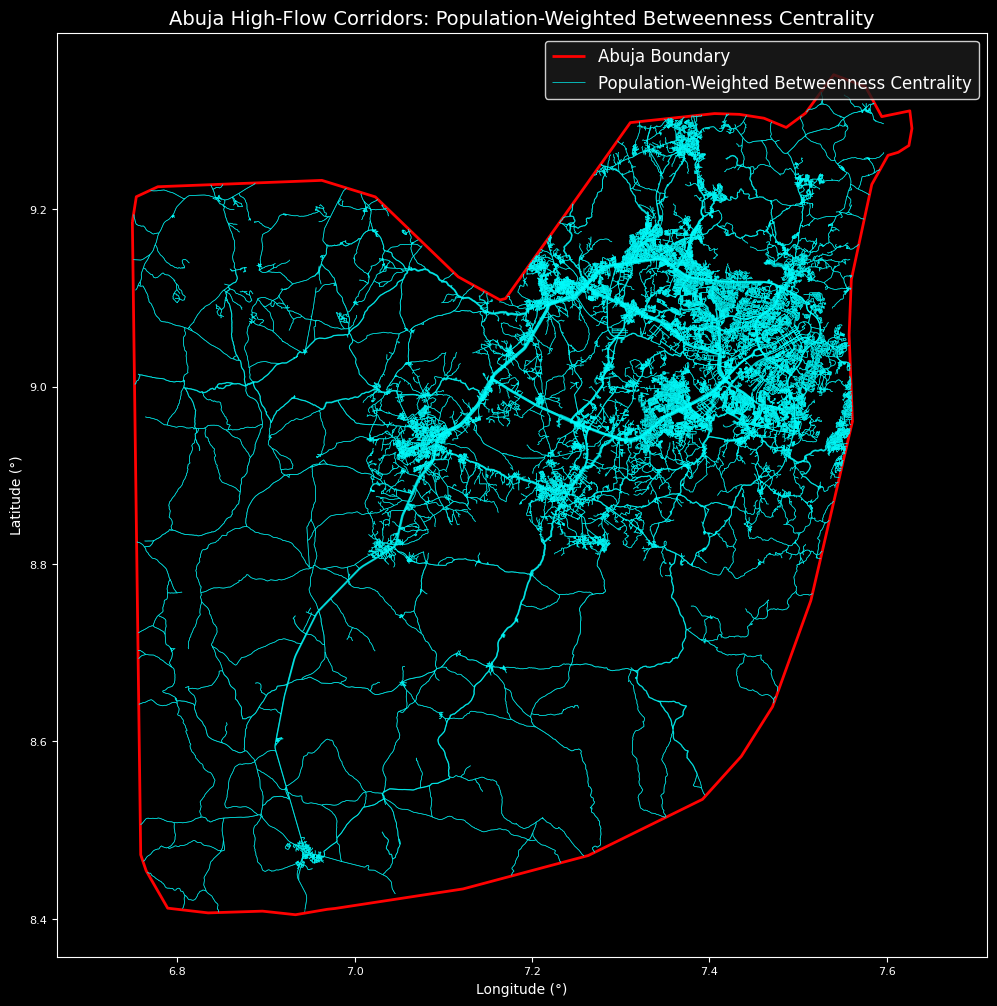

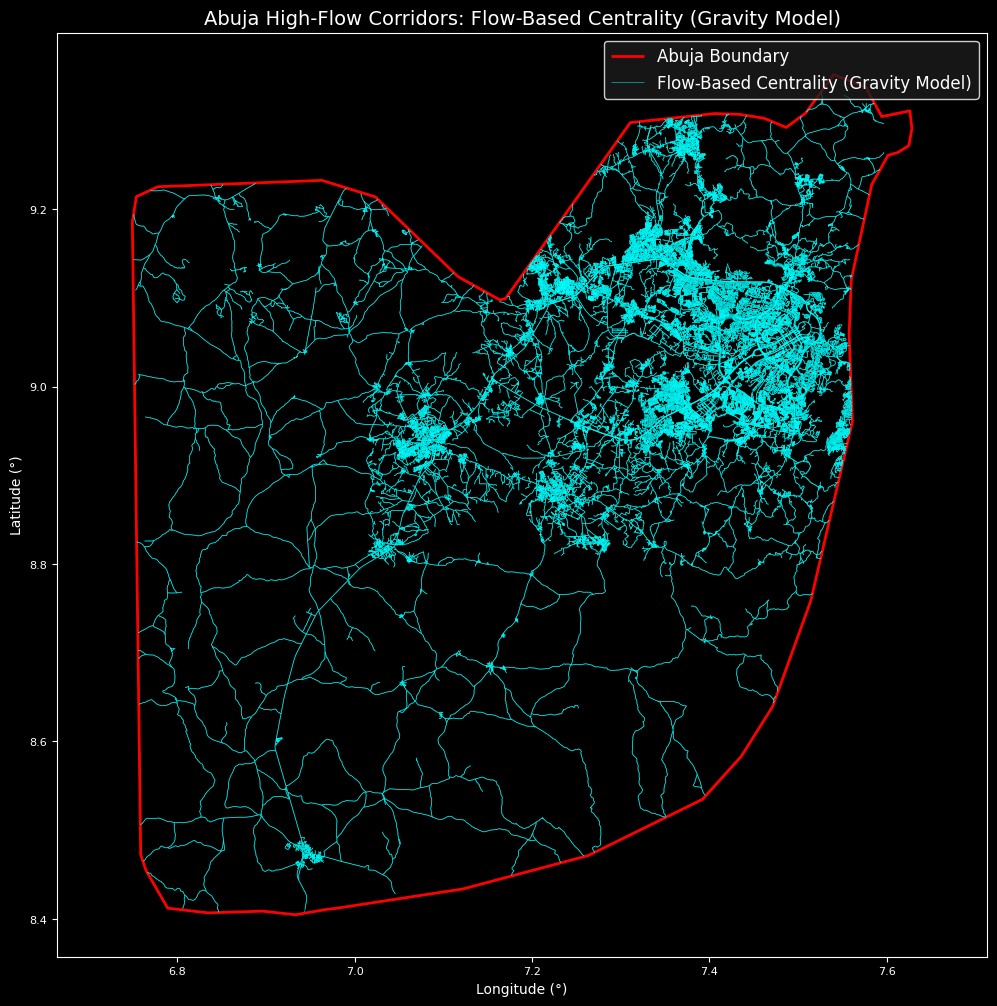

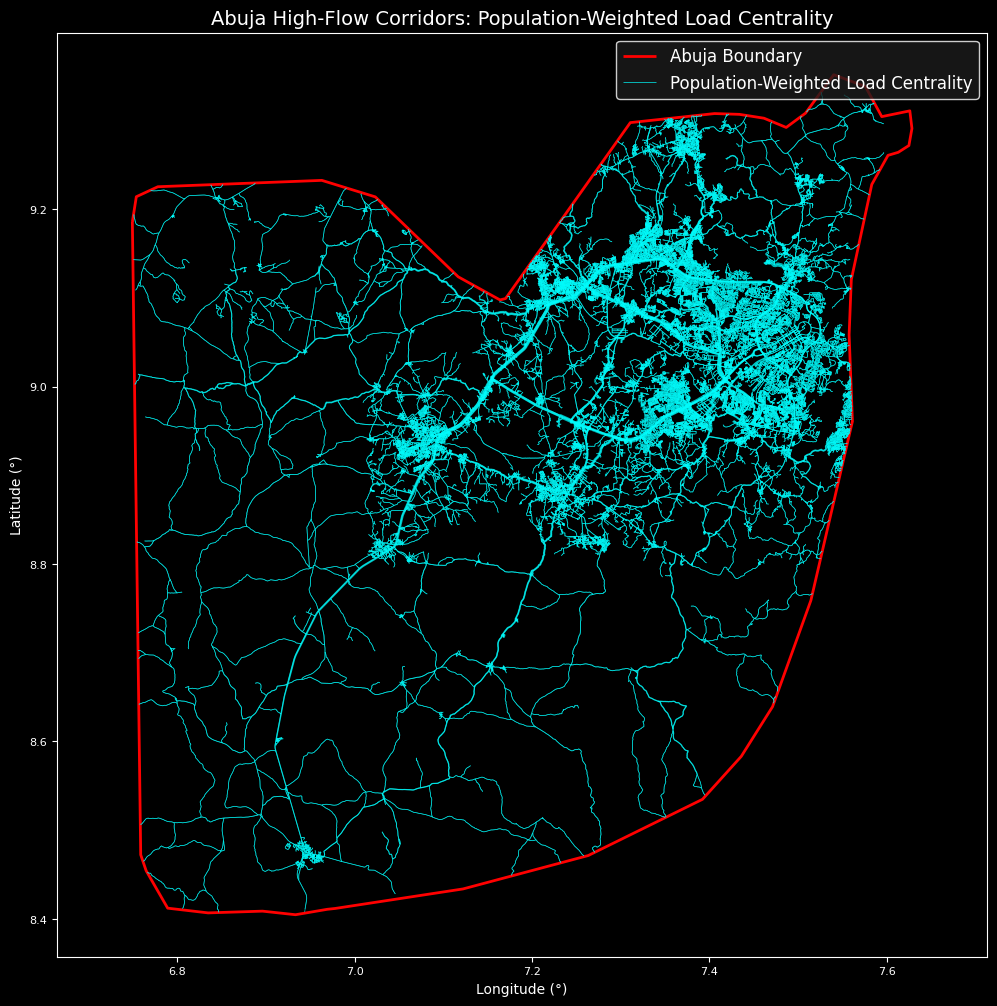

In [ ]:
# Define centrality measures and titles
centrality_measures = [
    ("pop_betweenness", "Population-Weighted Betweenness Centrality"),
    ("flow_centrality", "Flow-Based Centrality (Gravity Model)"),
    ("pop_load", "Population-Weighted Load Centrality")
]

plt.style.use("dark_background")

for measure, title in centrality_measures:
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot Abuja boundary
    abuja_gdf.boundary.plot(ax=ax, color="red", linewidth=2, label="Abuja Boundary")

    # Plot edges with variable thickness
    edge_gdf.plot(
        ax=ax,
        linewidth=edge_gdf[f"{measure}_line_width_matplotlib"],
        color="cyan",
        alpha=0.7,
        label=title
    )

    # Set title and legend
    plt.title(f"Abuja High-Flow Corridors: {title}", fontsize=14, color="white")
    plt.legend(loc="upper right", fontsize=12, frameon=True, facecolor="#1c1c1c", edgecolor="white", labelcolor="white")
    plt.axis("equal")
    plt.xlabel("Longitude (°)", fontsize=10, color="white")
    plt.ylabel("Latitude (°)", fontsize=10, color="white")
    plt.tick_params(axis="both", labelsize=8, colors="white")

    # Save and show
    plt.savefig(output_path / f"abuja_{measure}_map.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

In [ ]:
# Clean GeoDataFrame for folium compatibility
def clean_gdf(gdf):
    allowed = gdf.select_dtypes(include=["object", "float", "int", "bool"])
    return gpd.GeoDataFrame(allowed, geometry=gdf.geometry)

clean_edges = clean_gdf(edge_gdf)
clean_boundary = clean_gdf(abuja_gdf)

# Compute map center
bounds = edge_gdf.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2
m = Map(location=[center_lat, center_lon], zoom_start=11, tiles="CartoDB positron")

# Add Abuja boundary
GeoJson(
    clean_boundary,
    name="Abuja Boundary",
    style_function=lambda x: {"fillOpacity": 0, "color": "red", "weight": 4}
).add_to(m)

# Add edges for each centrality measure as separate layers
for measure, title in centrality_measures:
    GeoJson(
        clean_edges,
        name=title,
        style_function=lambda feature, m=measure: {
            "weight": feature["properties"][f"{m}_line_width_folium"],
            "color": "cyan",
            "opacity": 0.7,
            "popup": (
                f"Edge: {feature['properties']['u']} → {feature['properties']['v']}<br>"
                f"{title}: {feature['properties'][m]:.4f}"
            )
        }
    ).add_to(m)

# Add legend
legend_html = """
<div style="
    position: fixed;
    bottom: 20px;
    left: 20px;
    width: 220px;
    z-index:9999;
    background-color:white;
    padding: 10px;
    border:2px solid gray;
    border-radius:8px;
    font-size:14px;
">
<b>Legend</b><br>
<span style="color:cyan;">▬</span> Road Network (Thicker = Higher Centrality)<br>
<span style="color:red;">▬</span> Abuja Boundary
</div>
"""
m.get_root().html.add_child(Element(legend_html))

# Add layer control
LayerControl().add_to(m)

# Save and display
m.save(output_path / "abuja_centrality_measures_pop_weighted.html")
m

In [ ]:
# Print summary statistics
for measure in ["pop_betweenness", "flow_centrality", "pop_load"]:
    print(f"\n{measure} stats:")
    print(edge_gdf[measure].describe())

# Check correlations between centrality measures
print("\nCorrelation between centrality measures:")
print(edge_gdf[["pop_betweenness", "flow_centrality", "pop_load"]].corr())

# Verify high-flow corridors near high-population wards
top_wards = abuja_wards.nlargest(5, "Population")[["wardname", "Population", "nearest_node"]]
print("\nTop 5 wards by population:")
print(top_wards)

# Check edges near top wards
top_ward_nodes = set(top_wards["nearest_node"])
top_edges = edge_gdf[edge_gdf["u"].isin(top_ward_nodes) | edge_gdf["v"].isin(top_ward_nodes)]
print("\nEdges near top population wards:")
print(top_edges[["u", "v", "pop_betweenness", "flow_centrality", "pop_load"]].head())

In [ ]:
plt.style.use("dark_background")

for measure, title in centrality_measures:
    fig, ax = plt.subplots(figsize=(12, 12))

    # Plot Abuja boundary
    abuja_gdf.boundary.plot(ax=ax, color="red", linewidth=2, label="Abuja Boundary")

    # Define threshold for “high concentration”
    threshold = edge_gdf[measure].quantile(0.75)  # top 25%

    # Split edges into high vs low
    high_edges = edge_gdf[edge_gdf[measure] >= threshold]
    low_edges = edge_gdf[edge_gdf[measure] < threshold]

    # Plot low-weighted corridors (muted)
    low_edges.plot(
        ax=ax,
        linewidth=low_edges[f"{measure}_line_width_matplotlib"],
        color="gray",
        alpha=0.4
    )

    # Plot high-weighted corridors (highlighted)
    high_edges.plot(
        ax=ax,
        linewidth=high_edges[f"{measure}_line_width_matplotlib"],
        color="cyan",
        alpha=0.9,
        label=f"High {title}"
    )

    # Title and labels
    plt.title(f"Abuja High-Flow Corridors: {title}", fontsize=14, color="white")
    plt.legend(loc="upper right", fontsize=12, frameon=True, facecolor="#1c1c1c", edgecolor="white", labelcolor="white")
    plt.axis("equal")
    plt.xlabel("Longitude (°)", fontsize=10, color="white")
    plt.ylabel("Latitude (°)", fontsize=10, color="white")
    plt.tick_params(axis="both", labelsize=8, colors="white")

    # Save and show
    plt.savefig(output_path / f"abuja_{measure}_highlighted.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)
